In [ ]:
'''
Okay the plan;



1. We predict with sahi on the whole ortho image using different parameters (overlap, slice sizing) 
3. export each prediction as a seperate folder / yolo file format
2. We tile each prediction result image and bounding boxes into smaller images
    - this would basically be a dataset of original sized images along with a corresponding labels folder and a YAML file
3. randomly select 10% of images and label them in labelstudio
4. use fiftyone merge datasets to merge predict output tiles and labels with labelstudio groundtruth label and tiles
5. evaluate model performace and adjust confidence intervals
6. georef and make figures using the whole image predictions




'''

In [2]:
# first check the wd
# this should be AIggregation folder

import os
os.getcwd()

#os.chdir("..")


 100% |█████████████████████| 1/1 [16.7ms elapsed, 0s remaining, 69.8 samples/s] 



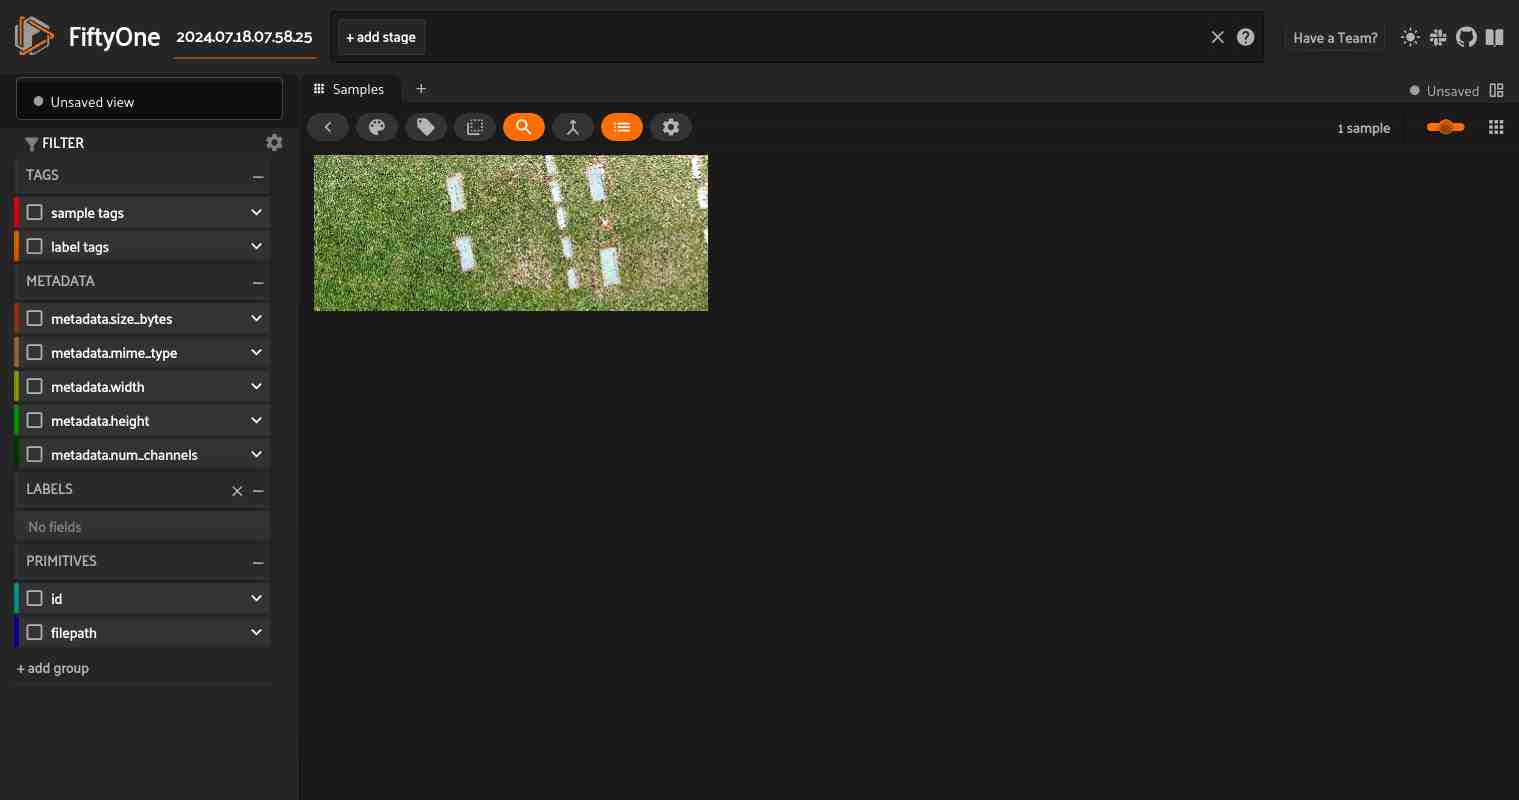

In [3]:

# import fiftyone
import fiftyone as fo
from fiftyone import ViewField as F


# Import ortho image into fiftyone dataset type
dataset = fo.Dataset.from_images(
    ["datasets/drone_ortho/ortho_clip_23april.png"]
)


# open test image instance to verify it loaded correctly
session = fo.launch_app(dataset)

In [4]:
# import sahi 
from sahi import AutoDetectionModel
from sahi.predict import get_prediction, get_sliced_prediction



# specify AI detection model
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov5',
    model_path='AIggregation_yolov5m/weights/best.pt', #specify path to trained model
    confidence_threshold=0.25,
    device="cpu", # or 'cuda:0'
)


# do a simple yolo prediction without slicing
# only on the first image in the dataset
result = get_prediction(dataset.first().filepath, detection_model)


# now do sliced prediction with sahi
sliced_result = get_sliced_prediction(
    dataset.first().filepath,
    detection_model,
    slice_height = 608,
    slice_width = 608,
    overlap_height_ratio = 0.1,
    overlap_width_ratio = 0.1
)


# compare number of detections with and without slicing just for fun
num_sliced_dets = len(sliced_result.to_fiftyone_detections())
num_orig_dets = len(result.to_fiftyone_detections())

print(f"Detections predicted without slicing: {num_orig_dets}")
print(f"Detections predicted with slicing: {num_sliced_dets}")



Performing prediction on 1210 slices.
Detections predicted without slicing: 0
Detections predicted with slicing: 1206


In [5]:



# Now to run and compare different slicing parameters
def predict_with_slicing(sample, label_field, **kwargs):
    result = get_sliced_prediction(
        sample.filepath, detection_model, verbose=0, **kwargs
    )
    sample[label_field] = fo.Detections(detections=result.to_fiftyone_detections())


#kwargs if you want to specify many arguments that are the same for all models
#kwargs = {"overlap_height_ratio": 0.2, "overlap_width_ratio": 0.2}

kwargs = {}


for sample in dataset.iter_samples(progress=True, autosave=True):
    predict_with_slicing(sample, label_field="small_slices", slice_height=304, slice_width=304, overlap_height_ratio = .2, overlap_width_ratio=.2, **kwargs)
    predict_with_slicing(sample, label_field="large_slices", slice_height=608, slice_width=608, overlap_height_ratio = .2, overlap_width_ratio=.2,  **kwargs)
    predict_with_slicing(sample, label_field="large_slices_overlap", slice_height=608, slice_width=608, overlap_height_ratio = .4, overlap_width_ratio=.4,  **kwargs)


#cant evaluate because no ground truthing
'''


# evaluate the different sahi predictions
large_slice_results = dataset.evaluate_detections("large_slices", gt_field="ground_truth", eval_key="eval_large_slices")
small_slice_results = dataset.evaluate_detections("small_slices", gt_field="ground_truth", eval_key="eval_small_slices")
overlap_slice_results = dataset.evaluate_detections("large_slices_overlap", gt_field="ground_truth", eval_key="eval_large_slices_overlap")

# print eval results
print("-" * 50)
print("Large slice results:")
large_slice_results.print_report()

print("-" * 50)
print("Large slice overlap results:")
overlap_slice_results.print_report()

print("-" * 50)
print("Small slice results:")
small_slice_results.print_report()

'''

#bring up new session to see boxes
session.show()




 100% |█████████████████████| 1/1 [25.7m elapsed, 0s remaining, 0.0 samples/s] 


07/18/2024 08:30:35 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [25.7m elapsed, 0s remaining, 0.0 samples/s] 
